In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
from langchain_teddynote import logging

logging.langsmith("TeddyNote-Parser", set_enable=False)

In [ ]:
from typing import TypedDict, Annotated, List
from io import BytesIO
import os
from PyPDF2 import PdfReader, PdfWriter
from state import (
    PdfState,
)  # 위에서 작성한 ParseState 임포트 (사용자 환경에 맞춰 수정)
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph


def ask_page_range(state: PdfState) -> bool:
    start_page = input("시작 페이지를 입력해주세요 : ")
    end_page = input("끝 페이지를 입력 해주세요 : ")

    try:
        state["startpage"] = int(start_page)
        state["endpage"] = int(end_page)
    except ValueError:
        print("페이지 번호 입력이 잘못되었습니다. 다시 입력해주세요.")
        raise ValueError("Invalid page range")

    return state


def split_pdf_in_memory(state: PdfState) -> bool:
    original_pdf_path = state["filepath"]
    if not os.path.isfile(original_pdf_path):
        print(f"원본 PDF를 찾을 수 없습니다: {original_pdf_path}")
        raise FileNotFoundError(f"File not found: {original_pdf_path}")

    # PDF 열기
    try:
        reader = PdfReader(original_pdf_path)
        writer = PdfWriter()
    except Exception as e:
        raise Exception(f"PDF 열기 오류: {e}")

    start_idx = state["startpage"] - 1
    end_idx = state["endpage"] - 1
    total_pages = len(reader.pages)

    if start_idx < 0 or end_idx >= total_pages or start_idx > end_idx:
        print("유효하지 않은 페이지 범위입니다.")
        raise ValueError("Invalid page range")

    # 지정 범위 페이지만 writer에 추가
    for page_num in range(start_idx, end_idx + 1):
        writer.add_page(reader.pages[page_num])

    # 메모리에 저장
    pdf_buffer = BytesIO()
    writer.write(pdf_buffer)
    pdf_buffer.seek(0)  # 포인터를 처음으로 이동

    splitted_bytes = pdf_buffer.read()  # 바이트로 읽음

    # state["split_pdf_data_list"]에 추가
    if "split_pdf_data_list" not in state or state["split_pdf_data_list"] is None:
        state["split_pdf_data_list"] = []

    state["split_pdf_data_list"].append(splitted_bytes)

    print(f"{state['startpage']}~{state['endpage']} 페이지 추출 완료 (메모리에만 저장)")

    return state


def ask_continue(state: PdfState) -> bool:
    answer = input("더 분할 하시겠습니까? (yes/no) : ").lower().strip()
    if answer == "yes":
        state["ask_human"] = True
    else:
        state["ask_human"] = False
    return state


def merge_splits_in_memory(state: PdfState) -> bool:
    file_name = input("파일 이름을 입력해주세요 : ")
    splitted_data_list = state.get("split_pdf_data_list", [])
    if not splitted_data_list:
        print("분할된 PDF가 없습니다.")
        raise ValueError("No splitted PDFs to merge.")

    writer = PdfWriter()
    try:
        for pdf_bytes in splitted_data_list:
            reader = PdfReader(BytesIO(pdf_bytes))
            for page in reader.pages:
                writer.add_page(page)

        merged_filename = f"../data/{file_name}.pdf"
        with open(merged_filename, "wb") as out:
            writer.write(out)

        print(f"모든 분할 PDF를 합쳐 {merged_filename} 을(를) 생성했습니다.")
    except Exception as e:
        raise Exception(f"PDF 합치기 오류: {e}")

    print("분할이 완료되었습니다.")
    return state


# --- 그래프 구성하기 ---
workflow = StateGraph(PdfState)

# 노드 등록
workflow.add_node("ask_page_range", ask_page_range)
workflow.add_node("split_pdf_in_memory", split_pdf_in_memory)
workflow.add_node("ask_continue", ask_continue)
workflow.add_node("merge_splits_in_memory", merge_splits_in_memory)

# 시작 노드
workflow.set_entry_point("ask_page_range")

# 흐름(Transition)
workflow.add_edge("ask_page_range", "split_pdf_in_memory")
workflow.add_edge("split_pdf_in_memory", "ask_continue")


def decide_next_step(state: PdfState):
    if state["ask_human"]:
        return "ask_page_range"  # 다시 페이지 범위 입력
    else:
        return "merge_splits_in_memory"  # 최종 병합


workflow.add_conditional_edges(
    "ask_continue",
    decide_next_step,
    {
        "ask_page_range": "ask_page_range",
        "merge_splits_in_memory": "merge_splits_in_memory",
    },
)

workflow.add_edge("merge_splits_in_memory", END)

# 그래프 컴파일
document_parse_graph = workflow.compile()

# (선택) 시각화
visualize_graph(document_parse_graph)

In [ ]:
file_path = "../data/pdf_data/test.pdf"

# config 설정
config = {"configurable": {"thread_id": "1"}}

document_parse_graph.invoke({"filepath": file_path}, config=config)

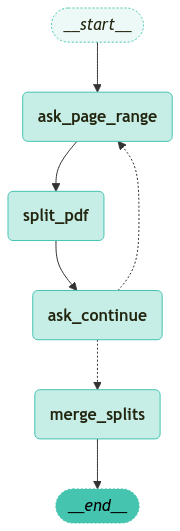

In [3]:
# 지정한 범위의 페이지별 문서 생성

from typing import TypedDict, Annotated, List
import os
from PyPDF2 import PdfReader, PdfWriter
from state import (
    PdfState as ParseState
)  # 위에서 작성한 ParseState 임포트 (사용자 환경에 맞춰 수정)
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

# --- 노드(함수) 정의 ---


def ask_page_range(state: ParseState) -> bool:
    start_page = input("시작 페이지를 입력해주세요 : ")
    end_page = input("끝 페이지를 입력 해주세요 : ")

    try:
        state["startpage"] = int(start_page)
        state["endpage"] = int(end_page)
    except ValueError:
        print("페이지 번호 입력이 잘못되었습니다. 다시 입력해주세요.")
        raise ValueError("Invalid page range")

    return state


def split_pdf(state: ParseState) -> bool:
    original_pdf_path = state["filepath"]
    if not os.path.isfile(original_pdf_path):
        print(f"원본 PDF 파일을 찾을 수 없습니다: {original_pdf_path}")
        raise FileNotFoundError(f"File not found: {original_pdf_path}")

    try:
        reader = PdfReader(original_pdf_path)
        writer = PdfWriter()
    except Exception as e:
        raise Exception(f"PDF 열기 오류: {e}")

    start_idx = state["startpage"] - 1  # PyPDF2는 0-based
    end_idx = state["endpage"] - 1
    total_pages = len(reader.pages)

    if start_idx < 0 or end_idx >= total_pages or start_idx > end_idx:
        print("유효하지 않은 페이지 범위입니다.")
        raise ValueError("Invalid page range")

    # 지정한 범위의 페이지만 추출
    for page_num in range(start_idx, end_idx + 1):
        writer.add_page(reader.pages[page_num])

    # 디스크에 분할 PDF 저장
    output_filename = f"output_split_{state['startpage']}-{state['endpage']}.pdf"
    with open(output_filename, "wb") as f:
        writer.write(f)

    # split_filepaths에 추가
    if "split_filepaths" not in state or state["split_filepaths"] is None:
        state["split_filepaths"] = []
    state["split_filepaths"].append(output_filename)

    print(
        f"{state['startpage']}~{state['endpage']} 페이지 추출 완료 -> {output_filename}"
    )
    return state


def ask_continue(state: ParseState) -> bool:
    answer = input("더 분할 하시겠습니까? (yes/no) : ").lower().strip()
    if answer == "yes":
        state["ask_human"] = True
    else:
        state["ask_human"] = False

    return state


def merge_splits(state: ParseState) -> bool:
    splitted_files = state.get("split_filepaths", [])
    if not splitted_files:
        print("분할된 PDF가 없습니다.")
        raise ValueError("No splitted PDFs to merge.")

    writer = PdfWriter()
    try:
        for pdf_path in splitted_files:
            if not os.path.isfile(pdf_path):
                raise FileNotFoundError(f"Cannot find splitted PDF: {pdf_path}")
            reader = PdfReader(pdf_path)
            for page in reader.pages:
                writer.add_page(page)

        merged_filename = "merged_output.pdf"
        with open(merged_filename, "wb") as out:
            writer.write(out)

        print(f"모든 분할 PDF를 합쳐서 {merged_filename} 을(를) 생성했습니다.")
    except Exception as e:
        raise Exception(f"PDF 합치기 오류: {e}")

    print("분할이 완료되었습니다.")
    return state


# --- 그래프 구성하기 ---
workflow = StateGraph(ParseState)

# 노드 등록
workflow.add_node("ask_page_range", ask_page_range)
workflow.add_node("split_pdf", split_pdf)
workflow.add_node("ask_continue", ask_continue)
workflow.add_node("merge_splits", merge_splits)

# 시작 노드 설정
workflow.set_entry_point("ask_page_range")

# 흐름(Transition)
workflow.add_edge("ask_page_range", "split_pdf")
workflow.add_edge("split_pdf", "ask_continue")


def decide_next_step(state: ParseState):
    if state["ask_human"]:
        return "ask_page_range"
    else:
        return "merge_splits"


workflow.add_conditional_edges(
    "ask_continue",
    decide_next_step,
    {
        "ask_page_range": "ask_page_range",
        "merge_splits": "merge_splits",
    },
)

workflow.add_edge("merge_splits", END)

# 컴파일
document_parse_graph = workflow.compile(checkpointer=MemorySaver())

# 시각화(선택)
visualize_graph(document_parse_graph)

In [4]:
file_path = "../data/pdf_data/test.pdf"

# config 설정
config = {"configurable": {"thread_id": "1"}}

document_parse_graph.invoke({"filepath": file_path}, config=config)

83~87 페이지 추출 완료 -> output_split_83-87.pdf
모든 분할 PDF를 합쳐서 merged_output.pdf 을(를) 생성했습니다.
분할이 완료되었습니다.


{'startpage': 83,
 'endpage': 87,
 'filepath': '../data/pdf_data/test.pdf',
 'split_filepaths': ['output_split_83-87.pdf'],
 'ask_human': False}